# Plotting Poster

In [1]:
import sys
sys.path.append('../datasets') 
import dataset_long as dsl

sys.path.append('../fitting') 
import paramfitt_singlePatient as pf 

# Model
import numpy as np
import tellurium as te
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Dataframe
import pandas as pd

#Estimation

from scipy.optimize import minimize 
from collections import OrderedDict
from scipy.stats import qmc
from scipy.optimize import basinhopping
#Analyse Estimation
from scipy.stats import chi2
from scipy.stats import norm

# Save optimization params
import json
import time

## Infection Simulation

14.501993331584593


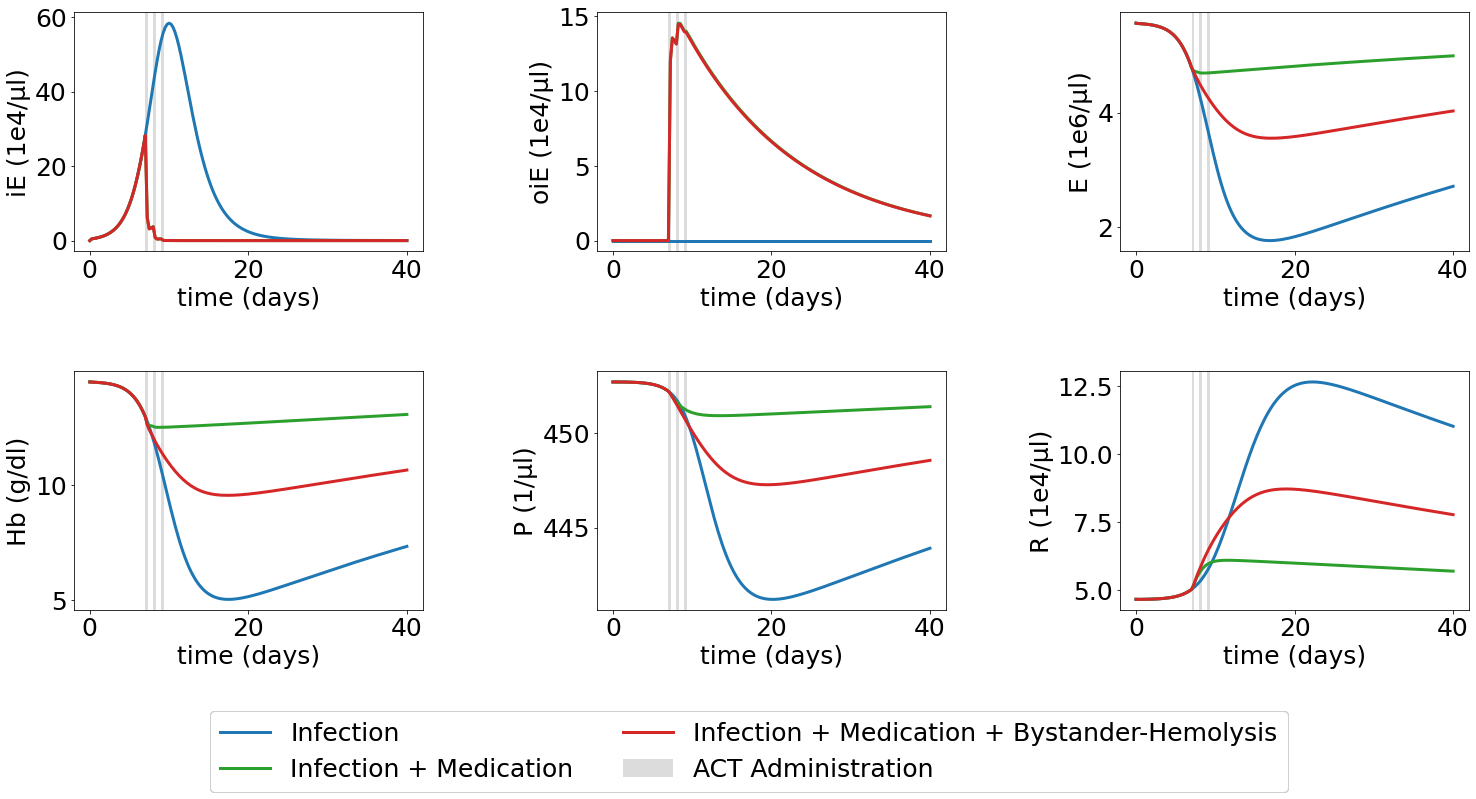

In [15]:
# Laden des Modells
OIE = te.loada('.././model/OIE_model.ant')
time_max =40
step_size = time_max * 4 + 1
size_of_font = 25

variables = ['iE','oiE', 'E', 'Hb', 'P', 'R']

print(OIE.Hb)
# Erstellen des Subplots
fig, axs = plt.subplots(2, 3, figsize=(25, 11))  #20,11
fig.subplots_adjust(hspace=0.5, wspace= 0.5)

units_dict = {'iE':1e4, 'oiE':1e4, 'E':1e6, 'Hb':1, 'P':1, 'R':1e4}

# Durchläufe für jede Variable
for i, var in enumerate(variables):
    OIE.resetToOrigin()
    OIE.events_medication_on = False
    OIE.BH_max = 0
    result1 = OIE.simulate(0, time_max, step_size, ['time', var])
    OIE.resetToOrigin()
    OIE.BH_max = 0
    OIE.Imax_iE = 7
    result2 = OIE.simulate(0, time_max, step_size, ['time', var])
    OIE.resetToOrigin()
    OIE.BH_max = 5
    OIE.Imax_iE = 7
    result3 = OIE.simulate(0, time_max, step_size, ['time', var])

    # Hinzufügen des Plots zum Subplot
    row = i // 3
    col = i % 3
    ax = axs[row, col]


    ax.plot(result1['time'], result1[var]/units_dict[var], label='Infection',color ='tab:blue',  linewidth=3)
    ax.plot(result2['time'], result2[var]/units_dict[var], label='Infection + Medication', color = 'tab:green',  linewidth=3)
    ax.plot(result3['time'], result3[var]/units_dict[var], label='Infection + Medication + Bystander-Hemolysis', color = 'tab:red', linewidth=3)
   
    #ax.axvspan(7, 9, facecolor='gray', alpha=1)
    ax.axvspan(7, 7.3, facecolor='gainsboro', alpha=1, label='ACT Administration')
    ax.axvspan(8, 8.3, facecolor='gainsboro', alpha=1)
    ax.axvspan(9, 9.3, facecolor='gainsboro', alpha=1)

    ax.tick_params(labelsize=size_of_font) # Größe Achseneinteilungen (zahlen)
    ax.set_xlabel('time (days)', fontsize= size_of_font)

    if var == 'Hb': ax.set_ylabel(var+ ' (g/dl)', fontsize= size_of_font) 
    elif var == 'R' or var == 'oiE': ax.set_ylabel(var+ ' (1e4/µl)', fontsize= size_of_font)
    elif var == 'E': ax.set_ylabel(var+' (1e6/µl)', fontsize= size_of_font)   
    elif var == 'iE': ax.set_ylabel(var+' (1e4/µl)', fontsize= size_of_font)  
    else: ax.set_ylabel(f'{var} ({units_dict[var]}/µl)', fontsize= size_of_font)
    
    #ax.set_title(var + '-Simulationen')
    ax.legend(fontsize = size_of_font, loc='upper right') # Größe legende

    handles, labels = ax.get_legend_handles_labels()  # Legend Box outsides Subplots
    fig.legend(handles, labels, loc='lower center', ncol =2,   bbox_to_anchor=(0.5, -0.12),  fontsize= size_of_font)
    
    ax.get_legend().remove()  # entfernt Legende aus einzelnen Plots
# Anzeigen der Plots
plt.show()


## PADH possible?

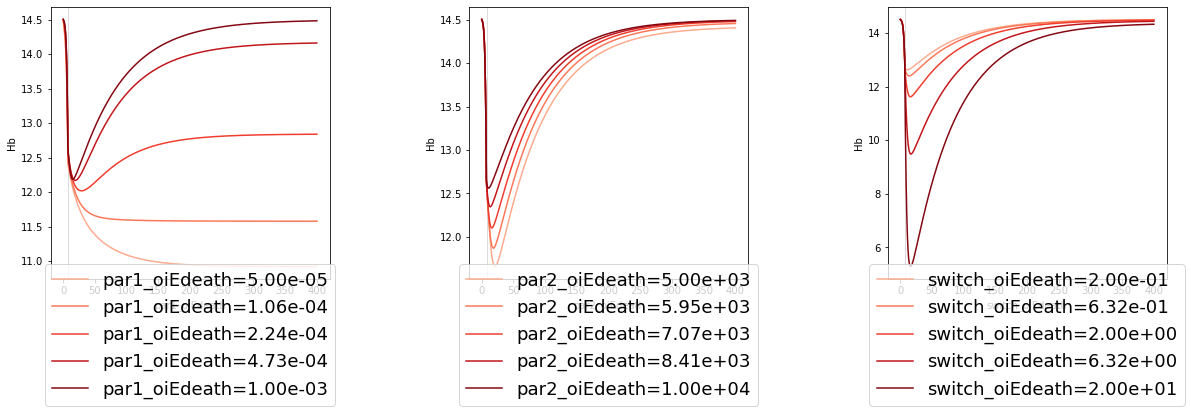

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import tellurium as te
from matplotlib import cm

size_of_font= 18


#Spezies
species_to_analyze = ['Hb']

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'k_BH': (5e-5, 1e-3),  #
    'J_oiEdeath_0': (5e3, 1e4),    #
    'BH_max': (2e-1, 20),
})


# Konvertiere bounds in logscale
params_bounds_log = pf.convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 5

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(1,3, figsize=(20, 5))
fig.subplots_adjust(hspace=0.5, wspace= 0.5)

#Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):

    for idx,value in enumerate(values):
        model = te.loada('.././model/OIE_model.ant')
 
        model_str = model.getAntimony()        #lade Antimony string
        model_lines = model_str.split('\n')    #splitte in für jede Zeile
        new_model_lines = []

        for line in model_lines:         #gehe alle zeielen durch, ändere wnn parameter geändert werden soll, füge in neuen strig zu
            if line.startswith(f'{param}=') or line.startswith(f'{param} '):   # if line.startswith(param):
                line = f'{param}={10**value}'
            new_model_lines.append(line)
        new_model_str = '\n'.join(new_model_lines)    
        model = te.loada(new_model_str) 

        result = model.simulate(0, 400, 4*400+1, ['time', 'Hb'])
        
        # Plot der Ergebnisse
        axs[i].plot(result['time'], result['Hb'],color=cmap(color_start + idx*(0.8/num_values_per_param)), label=f'{param}={10**value:.2e}')
        
        axs[i].axvspan(7, 7.3, facecolor='gainsboro', alpha=1)
        axs[i].axvspan(8, 8.3, facecolor='gainsboro', alpha=1)
        axs[i].axvspan(9, 9.3, facecolor='gainsboro', alpha=1)
        
        axs[i].set_xlabel(param)
        axs[i].set_ylabel('Hb')

        

        handles, labels = axs[i].get_legend_handles_labels()  # Legend Box outsides Subplots
        axs[i].legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.5),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.show()

#plt.savefig("plot.pdf")

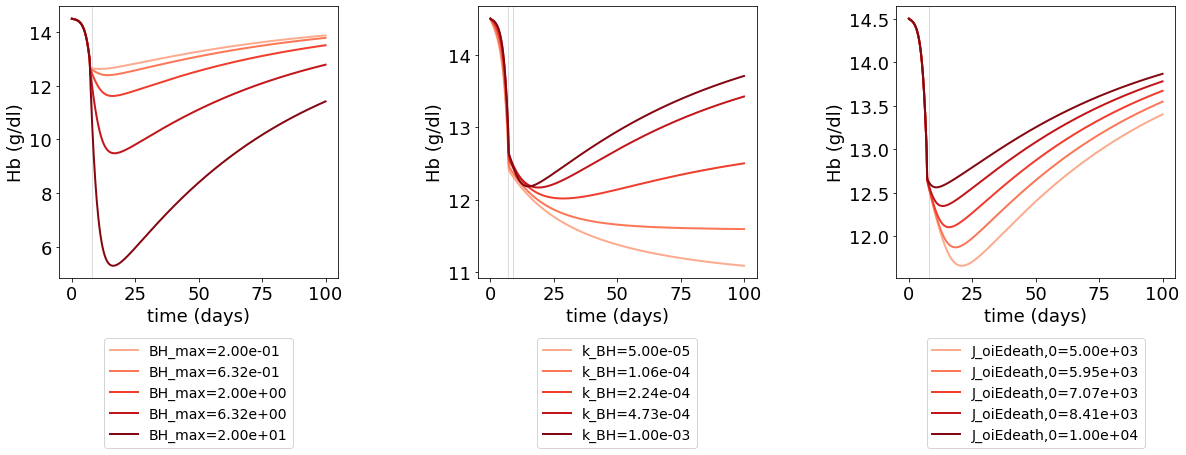

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import tellurium as te
from matplotlib import cm

size_of_font = 18

#Spezies
species_to_analyze = ['Hb']

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'BH_max': (2e-1, 20),
    'k_BH': (5e-5, 1e-3),  #
    'J_oiEdeath_0': (5e3, 1e4),    # 
})

params_names = OrderedDict({
    'BH_max': 'BH_max',
    'k_BH': 'k_BH',  #
    'J_oiEdeath_0': 'J_oiEdeath,0',    # 
})

# Konvertiere bounds in logscale
params_bounds_log = pf.convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 5

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(1,3, figsize=(20, 5))
fig.subplots_adjust(hspace=0.5, wspace= 0.5)

#Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):

    for idx,value in enumerate(values):
        model = te.loada('.././model/OIE_model.ant')
 
        model_str = model.getAntimony()        #lade Antimony string
        model_lines = model_str.split('\n')    #splitte in für jede Zeile
        new_model_lines = []

        for line in model_lines:         #gehe alle zeielen durch, ändere wnn parameter geändert werden soll, füge in neuen strig zu
            if line.startswith(f'{param}=') or line.startswith(f'{param} '):   # if line.startswith(param):
                line = f'{param}={10**value}'
            new_model_lines.append(line)
        new_model_str = '\n'.join(new_model_lines)    
        model = te.loada(new_model_str) 

        result = model.simulate(0, 100, 501, ['time', 'Hb'])
        
        # Plot der Ergebnisse
        axs[i].plot(result['time'], result['Hb'],color=cmap(color_start + idx*(0.8/num_values_per_param)), label=f'{params_names[param]}={10**value:.2e}',  linewidth=2)
        axs[i].axvspan(7, 7.3, facecolor='gainsboro', alpha=1, linewidth=2)
        axs[i].axvspan(8, 8.3, facecolor='gainsboro', alpha=1, linewidth=2)
        axs[i].axvspan(9, 9.3, facecolor='gainsboro', alpha=1, linewidth=2)

        axs[i].tick_params(labelsize=size_of_font)
    
        axs[i].set_xlabel('time (days)', fontsize =size_of_font)
        axs[i].set_ylabel('Hb (g/dl)', fontsize =size_of_font)

        handles, labels = axs[i].get_legend_handles_labels()  # Legend Box outsides Subplots
        axs[i].legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.65),fontsize =size_of_font-4) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.show()

#plt.savefig("plot.pdf")

## Fitting

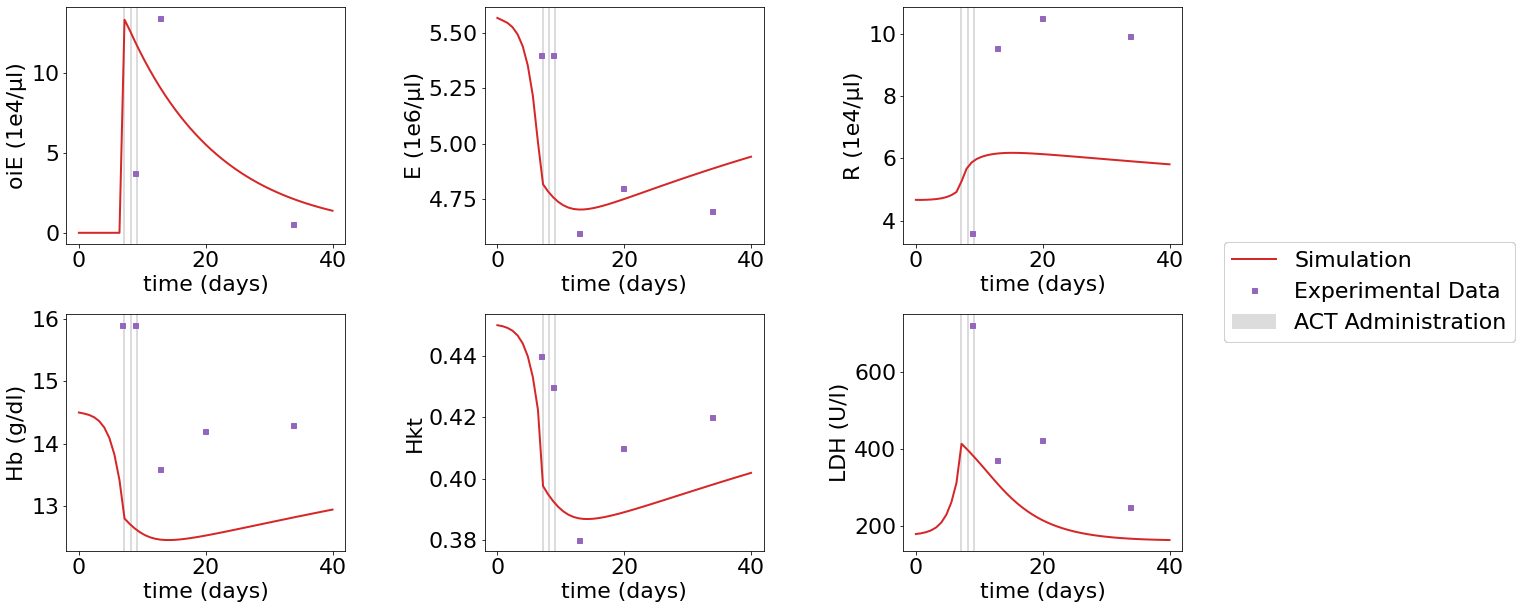

In [3]:

size_of_font = 22

# Load model
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)

# experimentel data
patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())

# Define lab and additional values
lab_values = ['[oiE]', '[E]', '[R]', 'Hb', 'Hkt', 'LDH'] # pf.get_lab_values()
additional_values = [] #['k_E_death', '[iE]', '[P]', 'J_P_death']
all_values = lab_values + additional_values

# define Units dictionary
units_dict = {'[iE]':1e4, '[oiE]':1e4, '[E]':1e6, 'Hb':1, '[P]':1, '[R]':1e4, 'Hkt': 1, 'LDH':1}

# Load optimization results
    #'20230707-16-12-18paras_optimized.json'
with open ('.././fitting/20230710-10-54-21paras_optimized.json', 'r') as jsonfile:    #r= only read
#with open ('20230707-17-53-05paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)


# Update model with new parameters
new_dict = optimize_results_file["results"][0]["best_params"]
ant_model = pf.update_model(ant_model, new_dict)

# Simulate the model
res = ant_model.simulate(0, 40, selections=['time']+ all_values)
df_simulated_data = pd.DataFrame(res, columns=res.colnames)

# Adjust time in experimental data
df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']

# Define number of rows and columns for the subplots
n_subplots = len(all_values)
n_cols = 3
n_rows = int(np.ceil(n_subplots/n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))  #15,8
fig.subplots_adjust(hspace=0.3 ,wspace= 0.5)

# Loop over all lab values and create a plot for each
for i, lab_value in enumerate(all_values):
    col = i%n_cols
    row = i//n_cols
    ax[row, col].plot(df_simulated_data.time, df_simulated_data[lab_value]/units_dict[lab_value], color = 'tab:red',  label = 'Simulation',  linewidth=2)
    if lab_value in df_experimental_data.columns:   
        ax[row, col].plot(df_experimental_data.time, df_experimental_data[lab_value]/units_dict[lab_value],'s',  markersize=5, color = 'tab:purple',  linewidth=2, label = 'Experimental Data')
    
    ax[row, col].axvspan(7, 7.3, facecolor='gainsboro', alpha=1, label='ACT Administration', linewidth=2)
    ax[row, col].axvspan(8, 8.3, facecolor='gainsboro', alpha=1,  linewidth=2)
    ax[row, col].axvspan(9, 9.3, facecolor='gainsboro', alpha=1,  linewidth=2)

    ax[row, col].tick_params(labelsize=size_of_font) # Größe Achseneinteilungen (zahlen)
    ax[row, col].set_xlabel('time (days)', fontsize= size_of_font)

    if lab_value == 'Hb': ax[row, col].set_ylabel('Hb (g/dl)', fontsize= size_of_font) 
    elif lab_value == '[R]': ax[row, col].set_ylabel('R (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[oiE]': ax[row, col].set_ylabel('oiE (1e4/µl)', fontsize= size_of_font)
    elif lab_value == '[E]': ax[row, col].set_ylabel('E (1e6/µl)', fontsize= size_of_font)   
    elif lab_value == 'iE': ax[row, col].set_ylabel('iE (1e4/µl)', fontsize= size_of_font) 
    elif lab_value == 'Hkt': ax[row, col].set_ylabel('Hkt', fontsize= size_of_font)   
    elif lab_value == 'LDH': ax[row, col].set_ylabel('LDH (U/l)', fontsize= size_of_font)   
    else: ax[row, col].set_ylabel(f'{lab_value} ({units_dict[lab_value]}/µl)', fontsize= size_of_font)
    
    ax[row, col].legend(fontsize = size_of_font, loc='upper right') # Größe legende

    handles, labels = ax[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots
    fig.legend(handles, labels, loc='lower center',   bbox_to_anchor=(1.03, 0.4),  fontsize= size_of_font)
    #0.5, -0.11
    ax[row, col].get_legend().remove()  # entfernt Legende aus einzelnen Plots

plt.show()
